# Imports

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

from datetime import datetime as dt
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import *
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN

import re

# Dataset

## Read

In [86]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## Total Family

In [87]:
df['TotalFamily'] = df['SibSp'] + df['Parch']
df_test['TotalFamily'] = df_test['SibSp'] + df_test['Parch']

## Get Title

The world is a cruel place. Well-recognized person is respected more. If age is less than 18, set title to Child.

In [88]:
def get_title(dfa):
    title = []
    recognized_title = ['Mr.', 'Mrs.', 'Miss.', 'Dr.', 'Major', 'Master', 'Rev', 'Ms.', 'Col.', 'Sir.', 'Capt.', 'Countess']

    for idx, name in enumerate(dfa['Name']):
        if dfa.loc[idx, 'Age'] < 18:
            title.append('Children')
            continue
        st = 0
        for tl in recognized_title:
            if tl in name:
                title.append(tl)
                st = 1
                break
        if not st:
            title.append('None')
    dfa['Title'] = title

    threshold = 5 # Anything that occurs less than this will be removed.
    value_counts = dfa['Title'].value_counts() 
    to_remove = value_counts[value_counts <= threshold].index
    dfa['Title'].replace(to_remove, 'Recognized', inplace=True)
    return (dfa)

df = get_title(df)
df_test = get_title(df_test)

## Cabin

In [89]:
# Fill missing value with a constant
df['Cabin'] = df['Cabin'].fillna('None')
df_test['Cabin'] = df_test['Cabin'].fillna('None')

# Get first letter
df['Cabin'] = [i[0] for i in df['Cabin']]
df_test['Cabin'] = [i[0] for i in df_test['Cabin']]

## Drop Col

In [90]:
col_to_drop = ['PassengerId', 'Name', 'Ticket']

df = df.drop(col_to_drop, axis = 1)
df_test_id = df_test['PassengerId']
df_test = df_test.drop(col_to_drop, axis = 1)
df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,TotalFamily,Title
0,0,3,male,22.0,1,0,7.2500,N,S,1,Mr.
1,1,1,female,38.0,1,0,71.2833,C,C,1,Mrs.


## Ordinal Encoder

In [91]:
col_to_ohe = ['Sex', 'Cabin', 'Embarked', 'Title']

ohe = OrdinalEncoder()
ohe.set_output(transform = 'pandas')

df[col_to_ohe] = ohe.fit_transform(df[col_to_ohe])
df_test[col_to_ohe] = ohe.transform(df_test[col_to_ohe])

## Check Label

<Axes: xlabel='Survived', ylabel='count'>

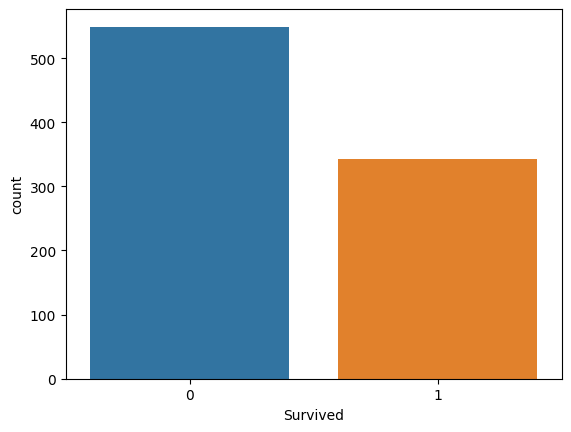

In [92]:
sns.countplot(df, x = 'Survived')

## Split X, y

In [93]:
X_train = df.drop('Survived', axis = 1)
y_train = df['Survived']
X_test = df_test

## Imputer for NaN

In [94]:
imputer = IterativeImputer(random_state=1333, initial_strategy='constant', min_value = 0, verbose = 1)
imputer.set_output(transform = 'pandas')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

[IterativeImputer] Completing matrix with shape (891, 10)
[IterativeImputer] Change: 43.58368467012794, scaled tolerance: 0.5123292 
[IterativeImputer] Change: 0.13195798668615888, scaled tolerance: 0.5123292 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (418, 10)


## Scaling

In [95]:
stdsc = StandardScaler()
stdsc.set_output(transform = 'pandas')

X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

# Tune

In [96]:
def tune(estimator, param_distribution, X, y, X_test, idcol, modelname = 'Model', cv = StratifiedKFold(5), n_iter = 50):
    cdt = dt.today().strftime('%Y-%m-%d')
    rs = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distribution,
        n_iter=n_iter,
        scoring='accuracy',
        cv=cv,
        verbose=2,
        random_state=423323,
        n_jobs=-1,
    )

    #CV results
    rs.fit(X, y)
    filename = '_'+modelname+'-'+str(cdt)+'-result.csv'
    pd.DataFrame(rs.cv_results_).to_csv(filename, index = False)
    print(rs.best_estimator_)

    model = rs.best_estimator_
    
    #Uncalibrated
    ypred = model.predict(X_test)
    submission = pd.DataFrame({
        'PassengerId' : idcol,
        'Survived' : ypred
    }) 
    filename = '_'+modelname+'-'+str(cdt)+'-submission.csv'
    submission.to_csv(filename, index = False)

    #Calibrated
    cal = CalibratedClassifierCV(model)
    cal.fit(X, y)

    ypred = cal.predict(X_test)
    submission = pd.DataFrame({
        'PassengerId' : idcol,
        'Survived' : ypred
    })
    filename = '_'+modelname+'-calibrated-'+str(cdt)+'-submission.csv'
    submission.to_csv(filename, index = False)

    return(pd.DataFrame(rs.cv_results_))

In [98]:
# define the parameter distributions to search over
param_distribution1_lgbm = {
    'lgbmclassifier__boosting_type': ['gbdt', 'dart'], #
    'lgbmclassifier__num_leaves': randint(10, 750),
    'lgbmclassifier__max_depth': [-1, 1, 3, 5, 10, 15, 20, 25], #can vary
    'lgbmclassifier__learning_rate': uniform(0.009, 0.3), #
    'lgbmclassifier__n_estimators': randint(25, 500), # can be extended
    'lgbmclassifier__min_child_samples': randint(5, 50),
    'lgbmclassifier__colsample_bytree': uniform(0, 1),
    'lgbmclassifier__subsample': uniform(0, 1),
    'lgbmclassifier__subsample_freq': randint(1, 10), # can be extended
    'lgbmclassifier__min_split_gain': uniform(0, 1),
    'lgbmclassifier__min_child_weight': uniform(1, 8),
    'lgbmclassifier__scale_pos_weight': uniform(0, 5),
    
}

# create an instance of the LGBMClassifier estimator
estimator_1 = make_pipeline(
    SMOTEENN(),
    LGBMClassifier(random_state=4244)
)

res_lgbm1_ada = tune(estimator_1, param_distribution1_lgbm, X_train, y_train, X_test, df_test_id, modelname = 'lgbm_basic', n_iter = 500)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


c:\Project\Git\sklearn-aio\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Project\Git\sklearn-aio\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Project\Git\sklearn-aio\.venv\Lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Project\Git\sklearn-aio\.venv\Lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weigh

Pipeline(steps=[('smoteenn', SMOTEENN()),
                ('lgbmclassifier',
                 LGBMClassifier(boosting_type='dart',
                                colsample_bytree=0.7364526335020855,
                                learning_rate=0.23972479577228878, max_depth=25,
                                min_child_samples=45,
                                min_child_weight=2.1193648464746495,
                                min_split_gain=0.08346165110987913,
                                n_estimators=468, num_leaves=382,
                                random_state=4244,
                                scale_pos_weight=0.6254224752598769,
                                subsample=0.7984138312187632,
                                subsample_freq=7))])


In [99]:
res_lgbm1_ada[res_lgbm1_ada['rank_test_score'] < 10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbmclassifier__boosting_type,param_lgbmclassifier__colsample_bytree,param_lgbmclassifier__learning_rate,param_lgbmclassifier__max_depth,param_lgbmclassifier__min_child_samples,param_lgbmclassifier__min_child_weight,...,param_lgbmclassifier__subsample_freq,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.112831,0.005289,0.007603,0.000794,gbdt,0.250817,0.116248,-1,19,3.306534,...,4,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.798883,0.808989,0.825843,0.797753,0.814607,0.809215,0.010428,8
114,0.162006,0.007484,0.006757,0.001648,gbdt,0.201248,0.085846,25,9,3.708187,...,7,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.798883,0.803371,0.820225,0.814607,0.808989,0.809215,0.007632,8
187,0.134416,0.009332,0.006399,0.003199,gbdt,0.318173,0.279542,10,48,1.017349,...,3,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.782123,0.808989,0.825843,0.831461,0.803371,0.810357,0.017510,7
193,0.204927,0.020956,0.007803,0.000394,gbdt,0.156822,0.108496,25,10,4.541133,...,3,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.810056,0.808989,0.803371,0.808989,0.831461,0.812573,0.009731,6
231,0.615916,0.026485,0.012803,0.003920,dart,0.736453,0.239725,25,45,2.119365,...,7,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.804469,0.808989,0.808989,0.831461,0.814607,0.813703,0.009443,1
348,0.129652,0.005695,0.004106,0.004393,gbdt,0.326647,0.121837,10,20,1.074257,...,4,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.837989,0.808989,0.814607,0.786517,0.820225,0.813665,0.016700,4
376,0.154581,0.007718,0.004800,0.003919,dart,0.401512,0.175085,3,18,1.20074,...,9,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.804469,0.814607,0.814607,0.808989,0.820225,0.812579,0.005391,5
406,0.096298,0.005295,0.006704,0.003404,gbdt,0.198183,0.14449,3,27,1.115117,...,2,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.821229,0.797753,0.792135,0.831461,0.825843,0.813684,0.015741,3
481,0.182090,0.020981,0.006007,0.003101,gbdt,0.856283,0.065669,-1,16,1.53505,...,1,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.810056,0.769663,0.820225,0.825843,0.842697,0.813697,0.024427,2
